In [3]:
import comp_utils
import pandas as pd
import numpy as np
import xarray as xr
from statsmodels.iolib.smpickle import load_pickle

api_instance = comp_utils.RebaseAPI()

# dwdから最新の風速を取得
latest_dwd_Hornsea1 = comp_utils.weather_df_to_xr(api_instance.get_hornsea_dwd())
latest_dwd_Hornsea1_features = latest_dwd_Hornsea1["WindSpeed:100"].mean(dim=["latitude","longitude"]).to_dataframe().reset_index()
latest_dwd_Hornsea1_features.rename(columns={"WindSpeed:100":"WindSpeed_dwd"},inplace=True)

# ncepから最新の風速を取得
latest_ncep_Hornsea1 = comp_utils.weather_df_to_xr(api_instance.get_hornsea_gfs())
latest_ncep_Hornsea1_features = latest_ncep_Hornsea1["WindSpeed:100"].mean(dim=["latitude","longitude"]).to_dataframe().reset_index()
latest_ncep_Hornsea1_features.rename(columns={"WindSpeed:100":"WindSpeed_ncep"},inplace=True)


# dwdから最新の日射量を取得
latest_dwd_solar = comp_utils.weather_df_to_xr(api_instance.get_pes10_nwp("DWD_ICON-EU"))
latest_dwd_solar_features = latest_dwd_solar["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
latest_dwd_solar_features.rename(columns={"SolarDownwardRadiation":"Radiation_dwd"},inplace=True)
latest_dwd_solar_features.loc[latest_dwd_solar_features["Radiation_dwd"] < 0, "Radiation_dwd"] = 0 # 負の値を0に修正

# ncepから最新の日射量を取得
latest_ncep_solar = comp_utils.weather_df_to_xr(api_instance.get_pes10_nwp("NCEP_GFS"))
latest_ncep_solar_features = latest_ncep_solar["SolarDownwardRadiation"].mean(dim="point").to_dataframe().reset_index()
latest_ncep_solar_features.rename(columns={"SolarDownwardRadiation":"Radiation_ncep"},inplace=True)
latest_ncep_solar_features.loc[latest_ncep_solar_features["Radiation_ncep"] < 0, "Radiation_ncep"] = 0 # 負の値を0に修正


# 気象データを結合
latest_forecast_table = latest_dwd_Hornsea1_features.merge(latest_ncep_Hornsea1_features,how="outer",on=["ref_datetime","valid_datetime"])
latest_forecast_table = latest_forecast_table.merge(latest_dwd_solar_features, how="outer", on=["ref_datetime", "valid_datetime"])
latest_forecast_table = latest_forecast_table.merge(latest_ncep_solar_features, how="outer", on=["ref_datetime", "valid_datetime"])

# 重複の削除
latest_forecast_table = latest_forecast_table.drop_duplicates(subset='valid_datetime')

# 30分間隔にリサンプリング、線形補間
latest_forecast_table.set_index('valid_datetime', inplace=True)
latest_forecast_table = latest_forecast_table.resample('30T').interpolate(method='linear')
latest_forecast_table.reset_index(inplace=True)
latest_forecast_table = latest_forecast_table[['ref_datetime', 'valid_datetime'] + [col for col in latest_forecast_table.columns if col not in ['ref_datetime', 'valid_datetime']]] # 列の入れ替え


# 分位点回帰
# 季節を決定する関数
def determine_season(month):
    if 3 <= month <= 5:
        return 'spring'
    elif 6 <= month <= 8:
        return 'summer'
    elif 9 <= month <= 11:
        return 'autumn'
    return 'winter'  # 12, 1, 2は冬

# ref_datetime列をdatetime型に変換
latest_forecast_table['ref_datetime'] = pd.to_datetime(latest_forecast_table['ref_datetime'])

# ref_datetimeから季節を決定
latest_forecast_table['season'] = latest_forecast_table['ref_datetime'].dt.month.apply(determine_season)

# 分位点回帰モデルを季節に基づいて適用
for quantile in range(10, 100, 10):
    for season in ['spring', 'summer', 'autumn', 'winter']:
        season_df = latest_forecast_table[latest_forecast_table['season'] == season]
        if not season_df.empty:
            model_path = f"/Users/narutakanomura/Desktop/local_compe/local_Getting Started/models_sea/model_{season}_q{quantile}.pickle"
            loaded_model = load_pickle(model_path)
            latest_forecast_table.loc[latest_forecast_table['season'] == season, f"q{quantile}"] = loaded_model.predict(season_df)
            latest_forecast_table.loc[latest_forecast_table[f"q{quantile}"] < 0, f"q{quantile}"] = 0

# 季節列を削除
latest_forecast_table.drop('season', axis=1, inplace=True)

# データ整形
energy_forecasting_data = pd.DataFrame({"datetime":comp_utils.day_ahead_market_times()})
energy_forecasting_data = energy_forecasting_data.merge(latest_forecast_table,how="left",left_on="datetime",right_on="valid_datetime")
columns_to_drop = ['ref_datetime', 'valid_datetime', 'WindSpeed_dwd', 'WindSpeed_ncep', 'Radiation_dwd', 'Radiation_ncep']
energy_forecasting_data = energy_forecasting_data.drop(columns=columns_to_drop)

# csvファイルを出力
energy_forecasting_data.to_csv("energy_forecasting_data.csv",index=False)

200
200
200
200


In [3]:
latest_forecast_table.head()

,ref_datetime,valid_datetime,WindSpeed_dwd,WindSpeed_ncep,Radiation_dwd,Radiation_ncep,q10,q20,q30,q40,q50,q60,q70,q80,q90
0,2023-12-26 18:00:00+00:00,2023-12-26 18:00:00+00:00,NaN,5.001612,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-12-26 18:00:00+00:00,2023-12-26 18:30:00+00:00,NaN,4.368345,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-12-26 18:00:00+00:00,2023-12-26 19:00:00+00:00,NaN,3.735078,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-12-26 18:00:00+00:00,2023-12-26 19:30:00+00:00,NaN,2.847456,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-12-26 18:00:00+00:00,2023-12-26 20:00:00+00:00,NaN,1.959835,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


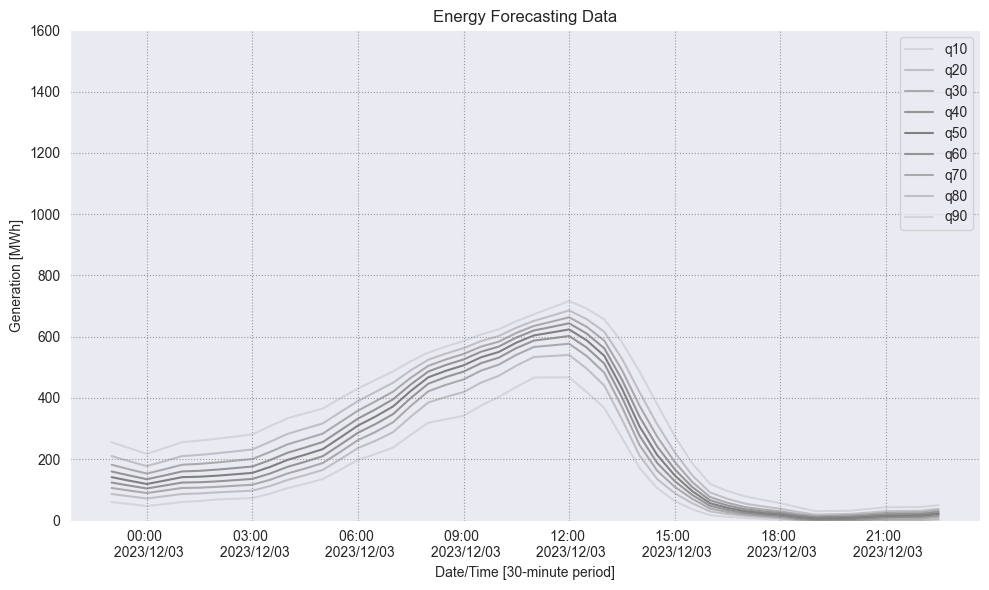

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates

# グラフの設定
plt.figure(figsize=(10, 6))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
ax = plt.gca()

# q10 から q90 までの各列に対してプロット
for quantile in range(10, 100, 10):
    sns.lineplot(data=energy_forecasting_data,
                 x='datetime',
                 y=f'q{quantile}',
                 color='gray',
                 alpha=1 - abs(50 - quantile) / 50,
                 label=f'q{quantile}')

plt.xlabel('Date/Time [30-minute period]')
plt.ylabel('Generation [MWh]')
plt.title('Energy Forecasting Data')
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M \n %Y/%m/%d"))
plt.ylim(0, 1600)
plt.tight_layout()
plt.show()